[**Blueprints for Text Analysis Using Python**](https://github.com/blueprints-for-text-analytics-python/blueprints-text)  
Jens Albrecht, Sidharth Ramachandran, Christian Winkler

**If you like the book or the code examples here, please leave a friendly comment on [Amazon.com](https://www.amazon.com/Blueprints-Text-Analytics-Using-Python/dp/149207408X)!**
<img src="../rating.png" width="100"/>


# Chapter 6:<div class='tocSkip'/>

# How to use classification algorithms to label text into multiple categories

## Remark<div class='tocSkip'/>

The code in this notebook differs slightly from the printed book. For example we frequently use pretty print (`pp.pprint`) instead of `print` and `tqdm`'s `progress_apply` instead of Pandas' `apply`. 

Moreover, several layout and formatting commands, like `figsize` to control figure size or subplot commands are removed in the book.

You may also find some lines marked with three hashes ###. Those are not in the book as well as they don't contribute to the concept.

All of this is done to simplify the code in the book and put the focus on the important parts instead of formatting.

## Setup<div class='tocSkip'/>

Set directory locations. If working on Google Colab: copy files and install required libraries.

In [8]:
import sys, os
ON_COLAB = 'google.colab' in sys.modules

if ON_COLAB:
    GIT_ROOT = 'https://github.com/blueprints-for-text-analytics-python/blueprints-text/raw/master'
    os.system(f'wget {GIT_ROOT}/ch06/setup.py')

%run -i setup.py

You are working on a local system.
Files will be searched relative to "..".


## Load Python Settings<div class="tocSkip"/>


In [6]:
conda install blueprints

Solving environment: failed with initial frozen solve. Retrying with flexible solve.
Solving environment: failed with initial frozen solve. Retrying with flexible solve.

PackagesNotFoundError: The following packages are not available from current channels:

  - blueprint

Current channels:

  - https://conda.anaconda.org/conda-forge/osx-arm64
  - https://conda.anaconda.org/conda-forge/noarch

To search for alternate channels that may provide the conda package you're
looking for, navigate to

    https://anaconda.org

and use the search bar at the top of the page.



Note: you may need to restart the kernel to use updated packages.


In [9]:
%run "$BASE_DIR/settings.py"

%reload_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = 'png'

# to print output of all statements and not just the last
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# otherwise text between $ signs will be interpreted as formula and printed in italic
pd.set_option('display.html.use_mathjax', False)

# path to import blueprints packages
sys.path.append(BASE_DIR + '/packages')

In [10]:
import matplotlib.pyplot as plt
import html 
import re
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
## Depracated:
# from sklearn.metrics import plot_confusion_matrix
## New version:
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.svm import LinearSVC
from sklearn.dummy import DummyClassifier
from blueprints.preparation import clean

## What you'll learn and what we will build

# Introducing the Java Development Tools Bug Dataset

In [33]:
file = "eclipse_jdt.csv"
file = f"{BASE_DIR}/data/jdt-bugs-dataset/eclipse_jdt.csv.gz" ### real location
df = pd.read_csv(file)
print (df.columns)
df[['Issue_id','Priority','Component','Title','Description']].sample(2, random_state=42)

Index(['Issue_id', 'Priority', 'Component', 'Duplicated_issue', 'Title',
       'Description', 'Status', 'Resolution', 'Version', 'Created_time',
       'Resolved_time'],
      dtype='object')


,Issue_id,Priority,Component,Title,Description
38438,239715,P3,UI,No property tester fo...,I20080613-2000; ; Not...
44129,395007,P3,UI,[package explorer] Re...,M3.; ; F5 (Refresh) i...


In [34]:
df = df.drop(columns=['Duplicated_issue']) ###
pd.set_option('display.max_colwidth', 25)
df.sample(1, random_state=123).T

,11811
Issue_id,33113
Priority,P3
Component,Debug
Title,Evaluating for loop s...
Description,Debug to a breakpoint...
Status,VERIFIED
Resolution,FIXED
Version,2.1
Created_time,2003-02-25 15:40:00 -...
Resolved_time,2003-03-05 17:11:17 -...


<Axes: xlabel='Priority'>

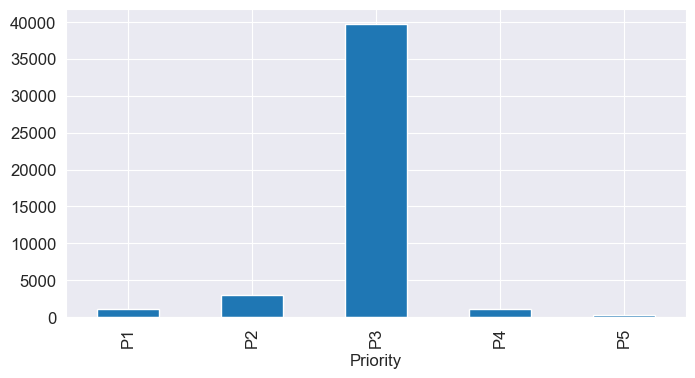

In [35]:
df['Priority'].value_counts().sort_index().plot(kind='bar')

In [36]:
df['Component'].value_counts()

Component
UI       17479
Core     13669
Debug     7542
Text      5901
APT        406
Doc        299
Name: count, dtype: int64

# Blueprint: Building a Text Classification system

## Step 1 - Data Preparation

In [37]:
df = df[['Title','Description','Priority']]
df = df.dropna()
df['text'] = df['Title'] + ' ' + df['Description']
df = df.drop(columns=['Title','Description'])
df.columns

Index(['Priority', 'text'], dtype='object')

In [38]:
from blueprints.preparation import clean
df['text'] = df['text'].apply(clean)
df = df[df['text'].str.len() > 50]
df.sample(2, random_state=0)

,Priority,text
42439,P3,Regression in TypeHie...
30486,P3,introduce indirection...


## Step 2 - Train-Test Split

In [39]:
X_train, X_test, Y_train, Y_test = train_test_split(df['text'],
                                                    df['Priority'],
                                                    test_size=0.2,
                                                    random_state=42,
                                                    stratify=df['Priority'])

print('Size of Training Data ', X_train.shape[0])
print('Size of Test Data ', X_test.shape[0])

Size of Training Data  36040
Size of Test Data  9011


## Step 3 - Training the machine learning model

In [40]:
tfidf = TfidfVectorizer(min_df = 10, ngram_range=(1,2), stop_words="english")
X_train_tf = tfidf.fit_transform(X_train)

In [41]:
model1 = LinearSVC(random_state=0, tol=1e-5)
model1.fit(X_train_tf, Y_train)

LinearSVC(random_state=0, tol=1e-05)

## Step 4 - Model Evaluation

In [42]:
X_test_tf = tfidf.transform(X_test)

In [43]:
Y_pred = model1.predict(X_test_tf)
print ('Accuracy Score - ', accuracy_score(Y_test, Y_pred))

Accuracy Score -  0.8761513705471091


In [44]:
clf = DummyClassifier(strategy='most_frequent', random_state=42)
clf.fit(X_train, Y_train)
Y_pred_baseline = clf.predict(X_test)
print ('Accuracy Score - ', accuracy_score(Y_test, Y_pred_baseline))

DummyClassifier(random_state=42, strategy='most_frequent')

Accuracy Score -  0.8769281988680502


### Precision and Recall


In [45]:
Y_pred = model1.predict(X_test_tf)
confusion_matrix(Y_test, Y_pred)

array([[  19,    1,  199,    4,    0],
       [   6,   18,  576,    8,    0],
       [   8,   48, 7827,   19,    0],
       [   0,    5,  192,   31,    0],
       [   0,    0,   50,    0,    0]])

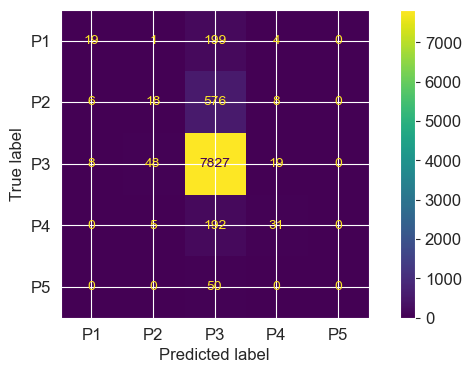

In [46]:
## Old code:

# plot_confusion_matrix(model1,X_test_tf,
#                       Y_test, values_format='d',
#                       cmap=plt.cm.Blues)
# plt.show()

## New code:

cm = confusion_matrix(Y_test, Y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels = model1.classes_)
disp.plot()
plt.show()

In [47]:
print(classification_report(Y_test, Y_pred))

              precision    recall  f1-score   support

          P1       0.58      0.09      0.15       223
          P2       0.25      0.03      0.05       608
          P3       0.89      0.99      0.93      7902
          P4       0.50      0.14      0.21       228
          P5       0.00      0.00      0.00        50

    accuracy                           0.88      9011
   macro avg       0.44      0.25      0.27      9011
weighted avg       0.82      0.88      0.83      9011



### Class Imbalance


In [48]:
# Filter bug reports with priority P3 and sample 4000 rows from it
df_sampleP3 = df[df['Priority'] == 'P3'].sample(n=4000, random_state=123)

# Create a separate dataframe containing all other bug reports
df_sampleRest = df[df['Priority'] != 'P3']

# Concatenate the two dataframes to create the new balanced bug reports dataset
df_balanced = pd.concat([df_sampleRest, df_sampleP3])

# Check the status of the class imbalance
df_balanced['Priority'].value_counts()

Priority
P3    4000
P2    3038
P4    1138
P1    1117
P5     252
Name: count, dtype: int64

# Final Blueprint for Text Classification

In [49]:
# Loading the balanced dataframe

df = df_balanced[['text', 'Priority']]
df = df.dropna()

# Step 1 - Data Preparation

df['text'] = df['text'].apply(clean)

# Step 2 - Train-Test Split
X_train, X_test, Y_train, Y_test = train_test_split(df['text'],
                                                    df['Priority'],
                                                    test_size=0.2,
                                                    random_state=42,
                                                    stratify=df['Priority'])
print('Size of Training Data ', X_train.shape[0])
print('Size of Test Data ', X_test.shape[0])

# Step 3 - Training the Machine Learning model

tfidf = TfidfVectorizer(min_df=10, ngram_range=(1, 2), stop_words="english")
X_train_tf = tfidf.fit_transform(X_train)

model1 = LinearSVC(random_state=0, tol=1e-5)
model1.fit(X_train_tf, Y_train)

# Step 4 - Model Evaluation

X_test_tf = tfidf.transform(X_test)
Y_pred = model1.predict(X_test_tf)
print('Accuracy Score - ', accuracy_score(Y_test, Y_pred))
print(classification_report(Y_test, Y_pred))

Size of Training Data  7636
Size of Test Data  1909


LinearSVC(random_state=0, tol=1e-05)

Accuracy Score -  0.5028810895756941
              precision    recall  f1-score   support

          P1       0.44      0.29      0.35       223
          P2       0.45      0.48      0.46       608
          P3       0.56      0.66      0.60       800
          P4       0.47      0.34      0.39       228
          P5       0.00      0.00      0.00        50

    accuracy                           0.50      1909
   macro avg       0.38      0.35      0.36      1909
weighted avg       0.48      0.50      0.49      1909



In [50]:
clf = DummyClassifier(strategy='stratified', random_state=21)
clf.fit(X_train, Y_train)
Y_pred_baseline = clf.predict(X_test)
print ('Accuracy Score - ', accuracy_score(Y_test, Y_pred_baseline))

DummyClassifier(random_state=21, strategy='stratified')

Accuracy Score -  0.31691985332634887


In [51]:
## Create a dataframe combining the Title and Description, 
## Actual and Predicted values that we can explore
frame = { 'text': X_test, 'actual': Y_test, 'predicted': Y_pred }
result = pd.DataFrame(frame)

result[((result['actual'] == 'P1') | (result['actual'] == 'P2')) &
       (result['actual'] == result['predicted'])].sample(2, random_state=22)

,text,actual,predicted
8461,Variable view show ol...,P1,P1
34854,model proxy created f...,P2,P2


In [52]:
result[((result['actual'] == 'P1') | (result['actual'] == 'P2')) &
       (result['actual'] != result['predicted'])].sample(2, random_state=33)

,text,actual,predicted
40065,Too many semicolons a...,P2,P3
7178,Next/Previous buttons...,P2,P3


# Cross-Validation

In [53]:
# Vectorization

tfidf = TfidfVectorizer(min_df = 10, ngram_range=(1,2), stop_words="english")
df_tf = tfidf.fit_transform(df['text']).toarray()

# Cross Validation with 5 folds

scores = cross_val_score(estimator=model1,
                         X=df_tf,
                         y=df['Priority'],
                         cv=5)

print ("Validation scores from each iteration of the cross validation ", scores)
print ("Mean value across of validation scores ", scores.mean())
print ("Standard deviation of validation scores ", scores.std())

Validation scores from each iteration of the cross validation  [0.48192771 0.45311682 0.43949712 0.42221058 0.37297014]
Mean value across of validation scores  0.43394447354635934
Standard deviation of validation scores  0.036211476115013436


# Hyperparameter Tuning with Grid Search

In [54]:
training_pipeline = Pipeline(
    steps=[('tfidf', TfidfVectorizer(
        stop_words="english")), ('model',
                                 LinearSVC(random_state=21, tol=1e-5))])

grid_param = [{
    'tfidf__min_df': [5, 10],
    'tfidf__ngram_range': [(1, 3), (1, 6)],
    'model__penalty': ['l2'],
    'model__loss': ['hinge'],
    'model__max_iter': [10000]
}, {
    'tfidf__min_df': [5, 10],
    'tfidf__ngram_range': [(1, 3), (1, 6)],
    'model__C': [1, 10],
    'model__tol': [1e-2, 1e-3]
}]

gridSearchProcessor = GridSearchCV(estimator=training_pipeline,
                                   param_grid=grid_param,
                                   cv=5)
gridSearchProcessor.fit(df['text'], df['Priority'])

best_params = gridSearchProcessor.best_params_
print("Best alpha parameter identified by grid search ", best_params)

best_result = gridSearchProcessor.best_score_
print("Best result identified by grid search ", best_result)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tfidf',
                                        TfidfVectorizer(stop_words='english')),
                                       ('model',
                                        LinearSVC(random_state=21,
                                                  tol=1e-05))]),
             param_grid=[{'model__loss': ['hinge'], 'model__max_iter': [10000],
                          'model__penalty': ['l2'], 'tfidf__min_df': [5, 10],
                          'tfidf__ngram_range': [(1, 3), (1, 6)]},
                         {'model__C': [1, 10], 'model__tol': [0.01, 0.001],
                          'tfidf__min_df': [5, 10],
                          'tfidf__ngram_range': [(1, 3), (1, 6)]}])

Best alpha parameter identified by grid search  {'model__loss': 'hinge', 'model__max_iter': 10000, 'model__penalty': 'l2', 'tfidf__min_df': 10, 'tfidf__ngram_range': (1, 3)}
Best result identified by grid search  0.4597171293871137


In [55]:
gridsearch_results = pd.DataFrame(gridSearchProcessor.cv_results_)
gridsearch_results[['rank_test_score', 'mean_test_score',
                    'params']].sort_values(by=['rank_test_score'])[:5]

,rank_test_score,mean_test_score,params
2,1,0.46,{'model__loss': 'hing...
0,2,0.46,{'model__loss': 'hing...
1,3,0.46,{'model__loss': 'hing...
3,4,0.46,{'model__loss': 'hing...
4,5,0.44,"{'model__C': 1, 'mode..."


# Blueprint recap and conclusion


In [56]:
# Flag that determines the choice of SVC (True) and LinearSVC (False)
runSVC = True

# Loading the dataframe

file = "eclipse_jdt.csv"
file = f"{BASE_DIR}/data/jdt-bugs-dataset/eclipse_jdt.csv.gz" ### real location
df = pd.read_csv(file)
df = df[['Title', 'Description', 'Component']]
df = df.dropna()
df['text'] = df['Title'] + df['Description']
df = df.drop(columns=['Title', 'Description'])

# Step 1 - Data Preparation
df['text'] = df['text'].apply(clean)
df = df[df['text'].str.len() > 50]

if (runSVC):
    # Sample the data when running SVC to ensure reasonable run-times
    df = df.groupby('Component', as_index=False).apply(pd.DataFrame.sample,
                                                       random_state=42,
                                                       frac=.2)

# Step 2 - Train-Test Split
X_train, X_test, Y_train, Y_test = train_test_split(df['text'],
                                                    df['Component'],
                                                    test_size=0.2,
                                                    random_state=42,
                                                    stratify=df['Component'])
print('Size of Training Data ', X_train.shape[0])
print('Size of Test Data ', X_test.shape[0])

# Step 3 - Training the Machine Learning model
tfidf = TfidfVectorizer(stop_words="english")

if (runSVC):
    model = SVC(random_state=42, probability=True)
    grid_param = [{
        'tfidf__min_df': [5, 10],
        'tfidf__ngram_range': [(1, 3), (1, 6)],
        'model__C': [1, 100],
        'model__kernel': ['linear']
    }]
else:
    model = LinearSVC(random_state=42, tol=1e-5)
    grid_param = {
        'tfidf__min_df': [5, 10],
        'tfidf__ngram_range': [(1, 3), (1, 6)],
        'model__C': [1, 100],
        'model__loss': ['hinge']
    }

training_pipeline = Pipeline(
    steps=[('tfidf', TfidfVectorizer(stop_words="english")), ('model', model)])

gridSearchProcessor = GridSearchCV(estimator=training_pipeline,
                                   param_grid=grid_param,
                                   cv=5)

gridSearchProcessor.fit(X_train, Y_train)

best_params = gridSearchProcessor.best_params_
print("Best alpha parameter identified by grid search ", best_params)

best_result = gridSearchProcessor.best_score_
print("Best result identified by grid search ", best_result)

best_model = gridSearchProcessor.best_estimator_

# Step 4 - Model Evaluation

Y_pred = best_model.predict(X_test)
print('Accuracy Score - ', accuracy_score(Y_test, Y_pred))
print(classification_report(Y_test, Y_pred))

Size of Training Data  7208
Size of Test Data  1802


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tfidf',
                                        TfidfVectorizer(stop_words='english')),
                                       ('model',
                                        SVC(probability=True,
                                            random_state=42))]),
             param_grid=[{'model__C': [1, 100], 'model__kernel': ['linear'],
                          'tfidf__min_df': [5, 10],
                          'tfidf__ngram_range': [(1, 3), (1, 6)]}])

Best alpha parameter identified by grid search  {'model__C': 1, 'model__kernel': 'linear', 'tfidf__min_df': 5, 'tfidf__ngram_range': (1, 6)}
Best result identified by grid search  0.7358510088444129
Accuracy Score -  0.7386237513873474
              precision    recall  f1-score   support

         APT       1.00      0.31      0.48        16
        Core       0.75      0.78      0.76       545
       Debug       0.90      0.77      0.83       300
         Doc       0.67      0.33      0.44        12
        Text       0.65      0.47      0.54       235
          UI       0.70      0.81      0.75       694

    accuracy                           0.74      1802
   macro avg       0.78      0.58      0.63      1802
weighted avg       0.74      0.74      0.73      1802



In [ ]:
clf = DummyClassifier(strategy='most_frequent', random_state=21)
clf.fit(X_train, Y_train)
Y_pred_baseline = clf.predict(X_test)
print ('Accuracy Score - ', accuracy_score(Y_test, Y_pred_baseline))

In [ ]:
## Create a dataframe combining the Title and Description, 
## Actual and Predicted values that we can explore
frame = { 'text': X_test, 'actual': Y_test, 'predicted': Y_pred } 
result = pd.DataFrame(frame)

result[result['actual'] == result['predicted']].sample(2, random_state=21)

In [ ]:
result[result['actual'] != result['predicted']].sample(2, random_state=42)

# Closing Remarks


# Further Reading
